# Curse of Dimensionality:

The goal of this demonstration is to illustrate the concept of the "Curse of Dimensionality", which refers to issues that arise in the increasingly high-dimensional space, simply because they are much larger, than our ordinary intuition thinks. As the number of variables that describe a sample of objects grows, the distance between sample objects increases rapidly, given the same sample size. If one is interested in exploring common 'features' of these objects, it becomes harder due to their growing dissimilarity.

As machine learning algorithms often deal with large numbers of variables, the balance between the size of the dataset and its dimensionality have to be kept in mind. Highly complex datasets have to be sampled sufficiently for an algorithm to arrive at a meaningful solution.

***

* Author: Vadim Rusakov & Troels C. Petersen (NBI)
* Email:  vadim.rusakovnbi.ku.dk & petersen@nbi.dk
* Date:   17th of April 2022

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, cdist
from scipy.special import gamma

First, let us start with an exmaple in two dimensions. We can create a random uniform sample from a circle with a unit radius $R=1$ by drawing random points from a square with a side $2R=2$ (Monte Carlo sampling). If a point has a distance from the origin $(0, 0)$ equal to  $d=\sqrt{x^2 + y^2} \leq 1$, then the point is accepted as part of the circle sample (red points below). Otherwise, it is rejected (blue points).

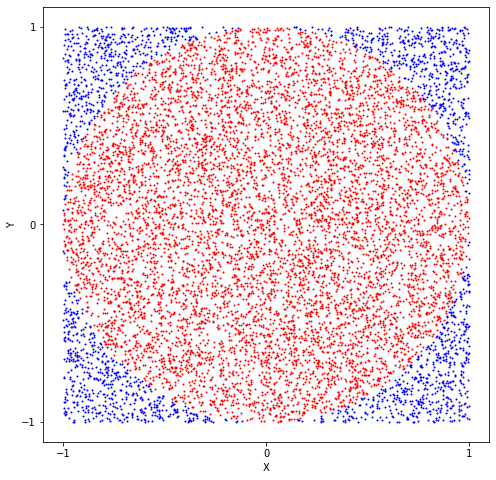

In [2]:
# Create a random uniform sample and compute distances as L2-norm
rng = np.random.default_rng(42)
all_points = rng.uniform(-1, 1, 2 * 10000).reshape(-1, 2)
distances = np.linalg.norm(all_points, ord=2, axis=1)
_incircle = distances < 1.0
_outcircle = distances > 1.0

# Plot the samples
fig, ax = plt.subplots(1, figsize=(8, 8),
                       subplot_kw={'xlabel': 'X',
                                   'ylabel': 'Y',
                                   'xticks': [-1, 0, 1], 
                                   'yticks': [-1, 0, 1]})
ax.scatter(all_points[_incircle,0], all_points[_incircle,1], s=1, c='r')
ax.scatter(all_points[_outcircle,0], all_points[_outcircle,1], s=1, c='b')
plt.show()

We have randomly sampled the circle, but notice that we had to create more points than needed for a circle to do that. In fact, only $\sim78 \%$ were acccepted. As we try to sample a circle in higher dimensions (a sphere in 3D or a hypersphere in $n$ dimensions), we have to create even larger samples, because the acceptance rate decreases at higher $n$. This happens as the volume of the hypercube outside of the hypersphere grows faster resulting in more points found outside of the hypersphere.

The acceptance rate is equal to the ratio of the volumes of the two shapes (in number counts). For a hypersphere and a hypercube (square in $n$ dimensions) we have:

$r=\frac{V_{sphere}}{V_{cube}} = \frac{\pi^{n/2}r^n / \Gamma(n/2+1)}{2^n}$

In [3]:
hsphere_vol = lambda n, r: np.pi**(0.5 * n) * r**n / (gamma(0.5 * n + 1.0))
hcube_vol = lambda n: 2.0**n
acceptance_rate = lambda n, r: hsphere_vol(n, r) / hcube_vol(n)

print("Aceptance rate r (in n dimensions):")
print(f"n=1, \t r={acceptance_rate(1, 1)*100:.2f}%")
print(f"n=2, \t r={acceptance_rate(2, 1)*100:.2f}%")
print(f"n=3, \t r={acceptance_rate(3, 1)*100:.2f}%")
print(f"n=10, \t r={acceptance_rate(10, 1)*100:.2f}%")

Aceptance rate r (in n dimensions):
n=1, 	 r=100.00%
n=2, 	 r=78.54%
n=3, 	 r=52.36%
n=10, 	 r=0.25%


Now let us sample a 10-dimensional unit hypersphere with $\sim 1000$ points. We calculated the acceptance rate for this case to be $r=0.25$%. Therefore, we know that to obtain 1000 points in our sample we need $1000 / 0.0025 = 400 000$ random points in a hypercube (with a side length $R=2$).

In [4]:
def plot_neighbours(m, n, r=1.0, seed=42):
    """
    Function to create a sample of an n-dimensional hypersphere 
    and plot point distances.
    
    m : (int) sample size
    n : (int) number of dimensions
    r : (float) radius of a hypersphere
    seed : (int) random number generator seed
    """

    # Create a random uniform sample:
    rng = np.random.default_rng(seed)
    points = rng.uniform(-r, r, m * n).reshape(m, n)

    # Calculate distances from the origin (0, 0) and point separations:
    moduli = np.linalg.norm(points, ord=2, axis=1)
    hsphere_points = points[moduli < r]
    hsphere_moduli = moduli[moduli < r]
    print(f"Number of points within the hsphere: \
            m={hsphere_points.shape[0]}/{points.shape[0]}\
            ({hsphere_points.shape[0]/points.shape[0]*100}%)")

    # Calculate point-point and point-edge distances:
    point_separations = cdist(hsphere_points, hsphere_points, metric='euclidean')
    diag_indices = np.diag_indices(point_separations.shape[0], ndim=2)
    _mask = np.zeros(shape=point_separations.shape)
    _mask[diag_indices] = 1.0
    point_separations = np.ma.masked_where(_mask, point_separations)    # Distance to other points
    edge_separations = r - hsphere_moduli                               # Distance to edge
    nearby_points = (point_separations < edge_separations).astype(int)
    nearby_points = nearby_points.sum(axis=1)
    
    # Plot histograms of distances:
    fig, ax = plt.subplots(1, figsize=(12, 5),
                           subplot_kw={'xlabel': 'distance',
                                       'ylabel': 'N'})
    h1, bins1, _ = ax.hist(edge_separations, bins=50, 
                           color='blue', density=True, 
                           label='Point-edge distance')
    h2, bins2, _ = ax.hist(point_separations.compressed(), bins=50, 
                           color='red', density=True, 
                           label='Point-point distance')
    ax.axvspan(edge_separations.min(), edge_separations.max(), 
               color='b', alpha=0.15)
    ax.axvspan(point_separations.min(), point_separations.max(), 
               color='r', alpha=0.1)
    ax.legend()
    plt.show()

    # Plot the histogram of number of closest neighbours before reaching the edge:
    bins = np.arange(21)
    fig, ax = plt.subplots(1, figsize=(12, 5),
                           subplot_kw={'yscale': 'log', 
                                       'xlim': (-1, 21), 
                                       # 'ylim': (0.5, 1e8), 
                                       'xticks': bins,
                                       'xlabel': 'K neighbours', 
                                       'ylabel': 'N'})
    hist, bins, _ = ax.hist(nearby_points.compressed(), bins=bins, 
                            color='blue', align='left', 
                            edgecolor='k', alpha=0.5)
    xy_annot = np.array([hist, bins[:-1]]).T
    xy_annot = xy_annot[xy_annot[:,0] > 0.0]
    for y, x in xy_annot:
        ax.annotate(f"{int(y)}", (x, y), xycoords="data", 
                    xytext=(0.0, 0.2), 
                    textcoords="offset points", 
                    ha = 'center', va = 'bottom')
    plt.show()

### Lonely in a large (dimensional) space?

We are interested in seeing how close the points in our sample are to each other. One way of looking at it is to compare the distance between the points and the edge of the hypersphere and the distance between every pair of points. We can call two points as close neighbours, if they are closer to each other than to the volume edge.

**Play around with dimensionality and number of points, and explore the loneliness in higher dimensionalities.**

NOTE: Recall that for some parameters, you're giving your computer a computationally tough (impossible?) task!

Number of points within the hsphere:             m=1026/400000            (0.2565%)


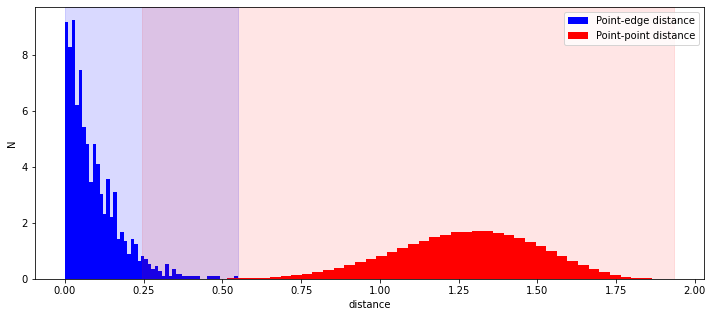

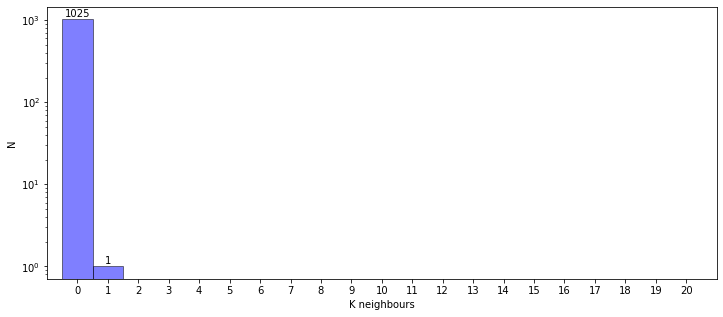

In [5]:
n_dimensions = 10        # i.e. number of input features
n_samples = 400000       # i.e. sample size
plot_neighbours(n_samples, n_dimensions, r=1.0, seed=42)

We see that for $n=10$ and $m=400000$ (i.e. $\sim 1000$ points in the hypersphere) we can get only $K=1$ (!) pair of nearby points (bottom panel). We also see that most of the points are much closer to the boundary than to each other (top panel; normalised counts).